In [1]:
from utils.config import Project_Config

IS_LORA = False
MODEL_NAME = "sd1-cifar10-v2"      #"sd1-cifar10-v2"

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
from diffusers import DiffusionPipeline
import torch

import os
p = "." + project_config.folder_symbol + MODEL_NAME
assert(os.path.isdir(p))

if IS_LORA:
    p = p + project_config.folder_symbol + "pytorch_lora_weights.safetensors"
    pipe = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
    if project_config.IS_CUDA:
        pipe.to("cuda")
    pipe.load_lora_weights(p)
else:
    pipe = DiffusionPipeline.from_pretrained(p)
    if project_config.IS_CUDA:
        pipe.to("cuda")
print("") #Stop ipynb dumping rubbish after this block

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


In [3]:
#This trick is directly based of something I found from DTRAK's code, see:
#https://github.com/sail-sg/D-TRAK/blob/main/ArtBench5/train_text_to_image_lora.py 
#line 1029 (at time of writing)
#Notably, their version does not work as is in current versions of diffusers, 
# and requires this slight adaption (creating a list of bools rather than a single bool)

def dummy(images, **kwargs):
        return images, [False]*len(images)

pipe.safety_checker = dummy

100%|██████████| 50/50 [00:01<00:00, 49.70it/s]


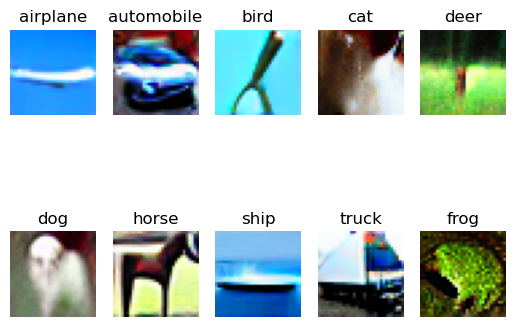

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

prompts=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'ship', 'truck', 'frog']
i = 0
for prompt in prompts:
    seed = 1
    generator = torch.Generator(device=("cuda" if project_config.IS_CUDA else "cpu")).manual_seed(seed)

    save_path = f"generated_images/{MODEL_NAME}/{str(seed)}/{prompt}/"
    os.makedirs(save_path, exist_ok=True)

    image = pipe(
        height=32,
        width=32,
        prompt=prompt,
        generator=generator,
    ).images[0]

    i=i+1
    plt.subplot(2, 5, i)
    plt.axis('off')
    plt.title(prompt)
    plt.imshow(image)

    image.save(save_path+prompt+".png")